In [1]:
import os
from glob import glob
import multiprocess as mp
from copy import deepcopy
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import mdtraj

from dist_analy.pypdb import Query, get_pdb_file
from dist_analy.dist_analy import get_shortest_dist_matrix, get_ca_dist_matrix
import dist_analy.import_pdb
import dist_analy.pca
from dist_analy.determine_seq import get_and_align_sequence, get_conserved, get_klifs_res, def_union
from dist_analy.util.pdb_info import pdb_csv, get_any_info
from dist_analy.alphaspace2.Community import get_community, view_surf_community, view_pocket
import dist_analy.alphaspace2 as AS2
from dist_analy.alphaspace2.Dock import DockPrep
from Bio import AlignIO


%load_ext autoreload
%autoreload 2

/Users/echen10/miniconda2/envs/dist_analy/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [85]:
import sklearn
print(sklearn.__file__)
print(sklearn.__version__)

/Users/echen10/miniconda2/envs/dist_analy/lib/python3.8/site-packages/sklearn/__init__.py
1.0.2


### Get the list of conserved residues across the CDK family

In [2]:
UNIPROT_LIST = ["P06493", "P24941", "Q00526", "P11802", "Q00535", "Q00534", "P50613", "P49336", "P50750", "Q15131", "Q9UQ88", "P21127", "Q9NYV4", \
"Q14004", "O94921", "Q96Q40", "Q00536", "Q00537", "Q07002", "Q9BWU1", "Q8IZL9"]
CDK1_20 = ['CDK1_HUMAN','CDK2_HUMAN','CDK3_HUMAN','CDK4_HUMAN','CDK5_HUMAN','CDK6_HUMAN','CDK7_HUMAN','CDK8_HUMAN','CDK9_HUMAN','CDK10_HUMAN','CD11A_HUMAN','CD11B_HUMAN','CDK12_HUMAN','CDK13_HUMAN','CDK14_HUMAN','CDK15_HUMAN','CDK16_HUMAN','CDK17_HUMAN','CDK18_HUMAN','CDK19_HUMAN','CDK20_HUMAN']

alignment = get_and_align_sequence( './datafiles/', 'CDK1_20', UNIPROT_LIST, prot_list=CDK1_20)
align = AlignIO.read('./datafiles/align/CDK1_20.al', "clustal")
cons_id = get_conserved(align)

klifs_res = [res for res in get_klifs_res('1FIN','A') if res]
cdk2_klifs_ident, union_id = def_union(cons_id[CDK1_20.index('CDK2_HUMAN')], klifs_res)

### Get the uniprot sequence for each kinase of the CDK family

In [3]:
uniprot_root = 'https://www.ebi.ac.uk/proteins/api/proteins/'
uniprot_seq_cdk2 = get_any_info(uniprot_root, UNIPROT_LIST[CDK1_20.index('CDK2_HUMAN')])["sequence"]["sequence"]

### Get all of the PDB structures associated with the CDK2 uniprot ID

In [6]:
cdk2_uniprot = 'P24941'
# editted pypdb to search by uniprot accession ... will need to submit a pull request eventually

found_pdbs = Query(cdk2_uniprot, query_type="uniprot").search()

In [8]:
outdir = './datafiles/raw_pdb/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
for pdb in found_pdbs:
    pdb_file = get_pdb_file(pdb, filetype='pdb', compression=False)
    fn = outdir + pdb + ".pdb"
    if not os.path.exists(fn):
        with open(fn,'w') as f1:
            f1.write(pdb_file)

### Create a .csv file with the characteristics of each of the PDB files

In [ ]:
csv_dict = pdb_csv(found_pdbs, cdk2_uniprot, "cdk2_pdb.csv")

### process the raw PDB structures (include non-canonical amino acids)

In [9]:
pdb_dir = './datafiles/raw_pdb/'
proc_dir = './datafiles/proc_pdb/CDK2/'

proc_pdb_list = []
NCAA = ['TPO', 'CSD', 'KCX', 'CSD', 'PTR', 'OCS', 'ALY']
pdb_proc = dist_analy.import_pdb.PDB_Processer(NCAA)
for pdb_fn in found_pdbs:
    pdb_list = pdb_proc.process_pdb(pdb_fn+'.pdb', pdb_dir, proc_dir, cdk2_uniprot)
    for proc in pdb_list:
#         print(proc)
        proc_pdb_list.append(proc)

1AQ1_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


1BUH_A.pdb
1CKP_A.pdb
1DI8_A.pdb
1DM2_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '8

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


1E9H_A.pdb
1E9H_C.pdb
1F5Q_A.pdb
1F5Q_C.pdb
1FIN_A.pdb
1FIN_C.pdb
1FQ1_B.pdb
1FVT_A.pdb
1FVV_A.pdb
1FVV_C.pdb
1G5S_A.pdb
1GIH_A.pdb
1GII_A.pdb
1GIJ_A.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 1GY3 entity #3, skipping
1GY3_A.pdb
1GY3_C.pdb
1GZ8_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


1H01_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


1H0V_A.pdb
1H0W_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', 

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-2': -999, '-1': -998, '0': -997, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-2': -999, '-1': -998, '0': -997, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 1OKV entity #3, skipping
1OKV_A.pdb
1OKV_C.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 1OKW entity #3, skipping
1OKW_A.pdb
1OKW_C.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 1OL1 entity #3, skipping
1OL1_A.pdb
1OL1_C.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 1OL2 entity #3, skipping
1OL2_A.pdb
1OL2_C.pdb
1P2A_A.pdb
1P5E_A.pdb
1P5E_C.pdb
1PF8_A.pdb
1PKD_A.pdb
1PKD_C.pdb
1PW2_A.pdb
1PXI_A.pdb
1PXJ_A.pdb
1PXK_A.pdb
1PXL_A.pdb
1PXM_A.pdb
1PXN_A.pdb
1PXO_A.pdb
1PXP_A.pdb
1PYE_A.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 1QMZ entity #3, skipping
1QMZ_A.pdb
1QMZ_C.pdb
1R78_A.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 1URC entity #3, skipping
1URC_A.pdb
1URC_C.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


1W98_A.pdb
1WCC_A.pdb
1Y8Y_A.pdb
1Y91_A.pdb
1YKR_A.pdb
2A0C_X.pdb
2A4L_A.pdb
2B52_A.pdb
2B53_A.pdb
2B54_A.pdb
2B55_A.pdb
2BHE_A.pdb
2BHH_A.pdb
{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2C5V entity #3, skipping
2C5V_A.pdb
2C5V_C.pdb
2C5X_A.pdb
2C5X_C.pdb
2C5Y_A.pdb
2C68_A.pdb
2C69_A.pdb
2C6I_A.pdb
2C6K_A.pdb
2C6L_A.pdb
2C6M_A.pdb
2C6O_A.pdb
2C6T_A.pdb
2C6T_C.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


2R64_A.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2UUE entity #3, skipping
2UUE_A.pdb
2UUE_C.pdb
2UZB_A.pdb
2UZB_C.pdb
2UZD_A.pdb
2UZD_C.pdb
2UZE_A.pdb
2UZE_C.pdb
2UZL_A.pdb
2UZL_C.pdb
2UZN_A.pdb
2UZO_A.pdb
2V0D_A.pdb
2V22_A.pdb
2V22_C.pdb
2VTA_A.pdb
2VTH_A.pdb
2VTI_A.pdb
2VTJ_A.pdb
2VTL_A.pdb
2VTM_A.pdb
2VTN_A.pdb
2VTO_A.pdb
2VTP_A.pdb
2VTQ_A.pdb
2VTR_A.pdb
2VTS_A.pdb
2VTT_A.pdb
2VU3_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


2W05_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


2W1H_A.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2WEV entity #3, skipping
2WEV_A.pdb
2WEV_C.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2WFY entity #3, skipping
2WFY_A.pdb
2WFY_C.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2WHB entity #3, skipping
2WHB_A.pdb
2WHB_C.pdb
2WIH_A.pdb
2WIH_C.pdb
{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', 

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2WMA entity #3, skipping
2WMA_A.pdb
2WMA_C.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2WMB entity #3, skipping
2WMB_A.pdb
2WMB_C.pdb
{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'-3': -999, '-2': -998, '-1': -997, '0': -996, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '41': '41', '42': '42', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 2X1N entity #3, skipping
2X1N_A.pdb
2X1N_C.pdb
2XMY_A.pdb
2XNB_A.pdb
3BHT_A.pdb
3BHT_C.pdb
3BHU_A.pdb
3BHU_C.pdb
3BHV_A.pdb
3BHV_C.pdb
3DDP_A.pdb
3DDP_C.pdb
3DDQ_A.pdb
3DDQ_C.pdb
3DOG_A.pdb
3DOG_C.pdb
3EID_A.pdb
3EID_C.pdb
3EJ1_A.pdb
3EJ1_C.pdb
3EOC_A.pdb
3EOC_C.pdb
3EZR_A.pdb
3EZV_A.pdb
3F5X_A.pdb
3F5X_C.pdb
3FZ1_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


3LE6_A.pdb
3LFN_A.pdb
3LFQ_A.pdb
3LFS_A.pdb
3MY5_A.pdb
3MY5_C.pdb
3NS9_A.pdb
3PJ8_A.pdb
3PXF_A.pdb
3PXQ_A.pdb
3PXR_A.pdb
3PXY_A.pdb
3PXZ_A.pdb
3PY0_A.pdb
3PY1_A.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 3QHR entity #3, skipping
3QHR_A.pdb
3QHR_C.pdb


/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 3QHW entity #3, skipping
3QHW_A.pdb
3QHW_C.pdb
3QL8_A.pdb
3QQF_A.pdb
3QQG_A.pdb
3QQH_A.pdb
3QQJ_A.pdb
3QQK_A.pdb
3QQL_A.pdb
3QRT_A.pdb
3QRU_A.pdb
3QTQ_A.pdb
3QTR_A.pdb
3QTS_A.pdb
3QTU_A.pdb
3QTW_A.pdb
3QTX_A.pdb
3QTZ_A.pdb
3QU0_A.pdb
3QWJ_A.pdb
3QWK_A.pdb
3QX2_A.pdb
3QX4_A.pdb
3QXO_A.pdb
3QXP_A.pdb
3QZF_A.pdb
3QZG_A.pdb
3QZH_A.pdb
3QZI_A.pdb
3R1Q_A.pdb
3R1S_A.pdb
3R1Y_A.pdb
3R28_A.pdb
3R6X_A.pdb
3R71_A.pdb
3R73_A.pdb
3R7E_A.pdb
3R7I_A.pdb
3R7U_A.pdb
3R7V_A.pdb
3R7Y_A.pdb
3R83_A.pdb
3R8L_A.pdb
3R8M_A.pdb
3R8P_A.pdb
3R8U_A.pdb
3R8V_A.pdb
3R8Z_A.pdb
3R9D_A.pdb
3R9H_A.pdb
3R9N_A.pdb
3R9O_A.pdb
3RAH_A.pdb
3RAI_A.pdb
3RAK_A.pdb
3RAL_A.pdb
3RJC_A.pdb
3RK5_A.pdb
3RK7_A.pdb
3RK9_A.pdb
3RKB_A.pdb
3RM6_A.pdb
3RM7_A.pdb
3RMF_A.pdb
3RNI_A.pdb
3ROY_A.pdb
3RPO_A.pdb
3RPR_A.pdb
3RPV_A.pdb
3RPY_A.pdb
3RZB_A.pdb
3S00_A.pdb
3S0O_A.pdb
3S1H_A.pdb
3S2P_A.pdb
3SQQ_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', 

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


3TI1_A.pdb
3TIY_A.pdb
3TIZ_A.pdb
3TNW_A.pdb
3TNW_C.pdb
3ULI_A.pdb
3UNJ_A.pdb
3UNK_A.pdb
3WBL_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


4BCK_A.pdb
4BCK_C.pdb
4BCM_A.pdb
4BCM_C.pdb
4BCN_A.pdb
4BCN_C.pdb
4BCO_A.pdb
4BCO_C.pdb
4BCP_A.pdb
4BCP_C.pdb
4BCQ_A.pdb
4BCQ_C.pdb
4BGH_A.pdb
4BZD_A.pdb
4CFM_A.pdb
4CFM_C.pdb
4CFN_A.pdb
4CFN_C.pdb
4CFU_A.pdb
4CFU_C.pdb
4CFV_A.pdb
4CFV_C.pdb
4CFW_A.pdb
4CFW_C.pdb
4CFX_A.pdb
4CFX_C.pdb
4D1X_A.pdb
4D1Z_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '6

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93', '94': '94'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


4EOI_A.pdb
4EOI_C.pdb
4EOJ_A.pdb
4EOJ_C.pdb
4EOK_A.pdb
4EOK_C.pdb
4EOL_A.pdb
4EOL_C.pdb
4EOM_A.pdb
4EOM_C.pdb
4EON_A.pdb
4EON_C.pdb
4EOO_A.pdb
4EOO_C.pdb
4EOP_A.pdb
4EOP_C.pdb
4EOQ_A.pdb
4EOQ_C.pdb
4EOR_A.pdb
4EOR_C.pdb
4EOS_A.pdb
4EOS_C.pdb
4ERW_A.pdb
4EZ3_A.pdb
4EZ7_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89', '90': '90', '91': '91', '92': '92', '93': '93'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85', '86': '86', '87': '87', '88': '88', '89': '89'

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


4FX3_A.pdb
4FX3_C.pdb
4GCJ_A.pdb
4I3Z_A.pdb
4I3Z_C.pdb
4II5_A.pdb
4II5_C.pdb
4KD1_A.pdb
4LYN_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


4RJ3_A.pdb
{'0': -999, '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', '23': '23', '24': '24', '25': '25', '26': '26', '27': '27', '28': '28', '29': '29', '30': '30', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '36', '37': '37', '38': '38', '39': '39', '40': '40', '43': '43', '44': '44', '45': '45', '46': '46', '47': '47', '48': '48', '49': '49', '50': '50', '51': '51', '52': '52', '53': '53', '54': '54', '55': '55', '56': '56', '57': '57', '58': '58', '59': '59', '60': '60', '61': '61', '62': '62', '63': '63', '64': '64', '65': '65', '66': '66', '67': '67', '68': '68', '69': '69', '70': '70', '71': '71', '72': '72', '73': '73', '74': '74', '75': '75', '76': '76', '77': '77', '78': '78', '79': '79', '80': '80', '81': '81', '82': '82', '83': '83', '84': '84', '85': '85',

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")


5AND_A.pdb
5ANE_A.pdb
5ANG_A.pdb
5ANI_A.pdb
5ANJ_A.pdb
5ANK_A.pdb
5ANO_A.pdb
5CYI_A.pdb
5CYI_C.pdb
5D1J_A.pdb
5FP5_A.pdb
5FP6_A.pdb
5IEV_A.pdb
5IEX_A.pdb
5IEY_A.pdb
5IF1_A.pdb
5IF1_C.pdb
5JQ5_A.pdb
5JQ8_A.pdb
5K4J_A.pdb
5L2W_A.pdb
5LMK_A.pdb
5LMK_C.pdb
5MHQ_A.pdb
5NEV_A.pdb
5NEV_C.pdb
5OO0_A.pdb
5OO1_A.pdb
5OO3_A.pdb
5OSJ_A.pdb
5OSM_A.pdb
5UQ1_A.pdb
5UQ1_C.pdb
5UQ2_A.pdb
5UQ3_A.pdb
6ATH_A.pdb
6GUB_A.pdb
6GUB_C.pdb
6GUC_A.pdb
6GUC_C.pdb
6GUE_A.pdb
6GUE_C.pdb
6GUF_A.pdb
6GUF_C.pdb
6GUH_A.pdb
6GUK_A.pdb
6GVA_A.pdb
6INL_A.pdb
6JGM_A.pdb
6OQI_A.pdb
6P3W_A.pdb
6P3W_C.pdb
6Q3B_A.pdb
6Q3C_A.pdb
6Q3F_A.pdb
6Q48_A.pdb
6Q49_A.pdb
6Q4A_A.pdb
6Q4B_A.pdb
6Q4C_A.pdb
6Q4D_A.pdb
6Q4E_A.pdb
6Q4F_A.pdb
6Q4G_A.pdb
6Q4H_A.pdb
6Q4I_A.pdb
6Q4J_A.pdb
6Q4K_A.pdb
6RIJ_A.pdb
6RIJ_C.pdb
6SG4_A.pdb
6SG4_C.pdb
6YL1_A.pdb
6YL6_A.pdb
6YLK_A.pdb
7ACK_A.pdb
7ACK_C.pdb
7B5L_L.pdb
7B5R_L.pdb
7B7S_A.pdb
7B7S_C.pdb
7E34_A.pdb
7KJS_A.pdb
7M2F_A.pdb
7MKX_A.pdb
7MKX_C.pdb
7NVQ_A.pdb
7QHL_A.pdb
7QHL_C.pdb
7RA5_A.pdb
7RWE_A.pdb

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 7UXI entity #2, skipping
{'1': '2', '2': '3', '3': '4', '4': '5', '5': '6', '6': '7', '7': '8', '8': '9', '9': '10', '10': '11', '11': '12', '12': '13', '13': '14', '14': '15', '15': '16', '16': '17', '17': '18', '18': '19', '19': '20', '20': '21', '21': '22', '22': '23', '23': '24', '24': '25', '25': '26', '26': '27', '27': '28', '28': '29', '29': '30', '30': '31', '31': '32', '32': '33', '33': '34', '34': '35', '35': '36', '36': '37', '37': '38', '45': '46', '46': '47', '47': '48', '48': '49', '49': '50', '50': '51', '51': '52', '52': '53', '53': '54', '54': '55', '55': '56', '56': '57', '57': '58', '58': '59', '59': '60', '60': '61', '61': '62', '62': '63', '63': '64', '64': '65', '65': '66', '66': '67', '67': '68', '68': '69', '69': '70', '70': '71', '71': '72', '72': '73', '73': '74', '74': '75', '75': '76', '76': '77', '77': '78', '78': '79', '79': '80', '80': '81', '81': '82', '82': '83', '83': '84', '84': '85', '85': '86', '86': '87', '87': '88', '88': 

/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/import_pdb.py:548: UserWarning: renumber with negative numbers
  warnings.warn("renumber with negative numbers")
/Users/echen10/Library/CloudStorage/GoogleDrive-eac709@nyu.edu/My Drive/dist_analy/dist_analy/util/pdb_info.py:369: UserWarning: No data found
  warnings.warn("No data found")


unable to find data with 7UXK entity #2, skipping
7UXK_A.pdb
7VDU_A.pdb
7ZPC_A.pdb
8B54_A.pdb
8B54_C.pdb
8CUR_A.pdb
8FOW_A.pdb
8FP0_A.pdb
8FP5_A.pdb
8H6P_A.pdb
8H6T_A.pdb


### calculate the distance matrices

In [35]:
proc_dir = '/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/'
save_dir = "./datafiles/npy/CDK2/"

dist_mat_list_tut = []
dist_mat_pdb_tut = []
for proc in glob(proc_dir+'*'):
    print(proc)
    pdb = proc.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    dist_mat = get_shortest_dist_matrix(proc, cdk2_klifs_ident, chain, save_dir=save_dir)
    dist_mat_list_tut.append(dist_mat)
    dist_mat_pdb_tut.append(pdb)

@> 2388 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1R_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C6K_A.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUE_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3O_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1P_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1URC_A.pdb


@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1CKP_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PKD_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2292 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1QMZ_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2FVD_A.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2234 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BPM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5JQ8_A.pdb


@> 2211 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BTS_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6YL6_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5NEV_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3WBL_A.pdb


@> 2252 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1W0X_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WMA_A.pdb


@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PXZ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3IGG_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2174 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R9N_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3BHT_C.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2298 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTL_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EK3_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R6X_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3BHV_A.pdb


@> 2315 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2CJM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOP_C.pdb


@> 2375 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1KE6_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OL2_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXN_A.pdb


@> 2368 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOR_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOK_C.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4I3Z_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKV_A.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4I3Z_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXL_A.pdb


@> 2362 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2161 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOK_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOR_C.pdb


@> 2299 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKO_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OL2_C.pdb


@> 4462 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKT_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOI_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QL8_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7NVQ_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2394 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RZB_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOP_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QQK_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2CJM_C.pdb


@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2211 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3BHV_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTN_A.pdb


@> 2371 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2303 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3UNK_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5OSM_A.pdb


@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5ANJ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3BHT_A.pdb


@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q3F_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2A0C_X.pdb


@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2131 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7S84_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WMA_C.pdb


@> 2380 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5NEV_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BPM_C.pdb


@> 2150 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PYE_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1E1X_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1HCK_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1QMZ_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PKD_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C6I_A.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1URC_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1P_C.pdb


@> 2301 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6YLK_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QWJ_A.pdb


@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUE_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1R_A.pdb


@> 2206 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2252 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1R78_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3M_A.pdb


@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3LE6_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFU_A.pdb


@> 2304 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2153 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7S4T_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2IW9_C.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2402 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2X1N_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1JST_A.pdb


@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PY1_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QTX_A.pdb


@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2308 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFW_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2A4L_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R73_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RAK_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2386 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RJC_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFN_A.pdb


@> 2325 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3SQQ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3I_A.pdb


@> 2268 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5K4J_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZO_A.pdb


@> 2284 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2443 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5OO3_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4GCJ_A.pdb


@> 2141 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3MY5_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C6T_C.pdb


@> 2329 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2297 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R8Z_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7QHL_A.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1VYW_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3R_A.pdb


@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1FVV_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUC_C.pdb


@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2227 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C6M_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKP_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2205 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QZG_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOM_C.pdb


@> 2337 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4J_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3SW4_A.pdb


@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2313 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOO_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7B7S_C.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2211 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q3B_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTQ_A.pdb


@> 2018 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2134 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7RWE_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5LMK_C.pdb


@> 2328 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EK5_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7MKX_A.pdb


@> 2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTJ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RK5_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2311 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R9H_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1BUH_A.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTS_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7MKX_C.pdb


@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5LMK_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RK7_A.pdb


@> 2296 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5IEY_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTH_A.pdb


@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7B7S_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOO_C.pdb


@> 2238 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKR_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4KD1_A.pdb


@> 2230 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1AQ1_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4H_A.pdb


@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXJ_A.pdb


@> 2517 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1FVV_C.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2172 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUC_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5OO1_A.pdb


@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3K_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1VYW_C.pdb


@> 2313 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7QHL_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C6T_A.pdb


@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3MY5_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C6O_A.pdb


@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3P_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R7U_A.pdb


@> 2260 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2316 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1FVT_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1JSV_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QTZ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFN_C.pdb


@> 2411 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2182 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFW_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2W05_A.pdb


@> 2402 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1JST_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2X1N_C.pdb


@> 2275 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2330 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3ULI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5Y_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2IW9_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3TIZ_A.pdb


@> 2185 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFU_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R71_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2354 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RAI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RM6_A.pdb


@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3BHU_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5ANK_A.pdb


@> 2137 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7S9X_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8FOW_A.pdb


@> 2195 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2284 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTT_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTO_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3UNJ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PXY_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4741 atoms and 1 coordinate set(s) were parsed in 0.05s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QU0_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKU_A.pdb


@> 2397 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BKZ_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOQ_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QQJ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OL1_A.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1KE5_A.pdb


@> 2374 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOJ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOS_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R1S_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QWK_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1P5E_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OIY_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2V22_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1S_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R7I_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H28_C.pdb


@> 2220 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2307 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3L_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2I40_A.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUF_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3TNW_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1Q_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UUE_C.pdb


@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2DS1_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WMB_A.pdb


@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2227 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RPY_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7S85_A.pdb


@> 2262 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2215 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1DI8_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BTR_A.pdb


@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2146 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RAL_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WMB_C.pdb


@> 2300 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4LYN_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UUE_A.pdb


@> 2222 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3N_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1Q_A.pdb


@> 2384 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3TNW_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUF_A.pdb


@> 2349 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2I40_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H28_A.pdb


@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6JGM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OIY_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H1S_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2V22_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1P5E_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QQH_A.pdb


@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOS_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R28_A.pdb


@> 2263 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOJ_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OL1_C.pdb


@> 2215 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKW_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKL_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2210 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R1Q_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOQ_C.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BKZ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2XNB_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXO_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1KE7_A.pdb


@> 2097 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2254 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7RXO_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5ANI_A.pdb


@> 2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2199 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7UG1_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2DUV_A.pdb


@> 2400 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8H6T_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R9O_A.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3BHU_C.pdb


@> 2367 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOL_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3SW7_A.pdb


@> 2330 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4I_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXK_A.pdb


@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H08_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EON_C.pdb


@> 4339 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKS_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QQL_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2400 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXP_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8H6P_A.pdb


@> 2254 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2286 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5IEX_A.pdb


@> 2210 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2291 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BHH_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5OSJ_A.pdb


@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2234 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5IF1_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EK6_A.pdb


@> 2409 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7RWF_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTR_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OI9_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WXV_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5X_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFM_A.pdb


@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2116 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2IW8_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5D1J_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RAH_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RM7_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2418 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1HCL_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFV_A.pdb


@> 2320 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3Q_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7ACK_A.pdb


@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2283 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZL_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5OO0_A.pdb


@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUB_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3J_A.pdb


@> 2185 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7S7A_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1W8C_A.pdb


@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUB_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZL_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 2340 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R7V_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C6L_A.pdb


@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2240 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3H_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZN_A.pdb


@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2130 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7ACK_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFV_C.pdb


@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2167 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3TIY_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1V1K_A.pdb


@> 2205 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2W06_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3S1H_A.pdb


@> 2237 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6YL1_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5X_C.pdb


@> 2130 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2141 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2IW8_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFM_C.pdb


@> 2302 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2380 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1JSU_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OI9_A.pdb


@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WXV_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PY0_A.pdb


@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2326 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5IF1_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2JGZ_A.pdb


@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2263 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q3C_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTP_A.pdb


@> 2229 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5ANO_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PXF_A.pdb


@> 2303 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2300 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PJ8_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EK4_A.pdb


@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKJ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PXI_A.pdb


@> 2406 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EON_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4K_A.pdb


@> 2250 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKQ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QZF_A.pdb


@> 2405 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EOL_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3ROY_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2103 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6SG4_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5CYI_C.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2271 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OKW_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4G_A.pdb


@> 2238 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2281 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6ATH_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EID_C.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PXQ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QHR_C.pdb


@> 2386 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OGU_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3DDP_A.pdb


@> 2280 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5IEV_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QRT_A.pdb


@> 2252 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q48_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EK8_A.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2359 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5O_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FX3_C.pdb


@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2371 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GVA_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WFY_A.pdb


@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2354 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCP_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2IW6_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5V_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R83_A.pdb


@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2403 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFX_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCK_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QTU_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WEV_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3TI1_A.pdb


@> 2246 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1VYZ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7E34_A.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3F5X_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1B38_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2CCH_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RMF_A.pdb


@> 2106 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2348 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OIQ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8B54_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R8L_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZB_A.pdb


@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2348 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZB_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8B54_C.pdb


@> 2176 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5FP6_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3F5X_A.pdb


@> 2390 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R8U_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2CCH_A.pdb


@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3S2P_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3F_A.pdb


@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WEV_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RNI_A.pdb


@> 2305 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VU3_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCK_C.pdb


@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4CFX_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2IW6_C.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2150 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5V_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCP_C.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WFY_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QTW_A.pdb


@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7KJS_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5O_A.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2361 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FX3_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4ERW_A.pdb


@> 2911 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2219 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2B54_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2J9M_A.pdb


@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2185 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3DDP_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OGU_C.pdb


@> 2355 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5UQ2_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QHR_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2278 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3S00_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1WCC_A.pdb


@> 2290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2362 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4E_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3S0O_A.pdb


@> 2270 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7M2F_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R1Y_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2305 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QZH_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EID_A.pdb


@> 2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2107 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1G5S_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6SG4_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OKW_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5CYI_A.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1YKR_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5ANE_A.pdb


@> 2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7RA5_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1FIN_A.pdb


@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7VDU_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3DOG_C.pdb


@> 2152 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VTA_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5MHQ_A.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WHB_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2G9X_A.pdb


@> 2169 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2194 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H00_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6INL_A.pdb


@> 2344 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2149 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4A_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H26_C.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZD_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6OQI_A.pdb


@> 2134 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OIU_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H24_A.pdb


@> 2297 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2157 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EOC_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BZD_A.pdb


@> 2199 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1GIJ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WIP_C.pdb


@> 2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2375 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BGH_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCM_A.pdb


@> 2189 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1P2A_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5JQ5_A.pdb


@> 2279 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7B5R_L.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QTS_A.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1Y8Y_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C69_A.pdb


@> 2163 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2248 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCO_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1F5Q_C.pdb


@> 2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8FP5_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QTQ_A.pdb


@> 2346 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1F5Q_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCO_A.pdb


@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCM_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WIP_A.pdb


@> 2302 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUH_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H24_C.pdb


@> 2357 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2317 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2CLX_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EOC_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R7E_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OIU_A.pdb


@> 2223 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1GIH_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZD_C.pdb


@> 2389 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2151 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H26_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1URW_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2240 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QQF_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3IG7_A.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1FQ1_B.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2G9X_C.pdb


@> 2367 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4C_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WHB_A.pdb


@> 2250 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2206 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1KE9_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2W17_A.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2155 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3DOG_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5ANG_A.pdb


@> 2278 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2W1H_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1FIN_C.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2311 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2B52_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H0V_A.pdb


@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2359 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5A14_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCQ_C.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RPR_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5N_A.pdb


@> 2279 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2197 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7B5L_L.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8FP0_A.pdb


@> 2332 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3LFQ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QX2_A.pdb


@> 2285 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OIR_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R3G_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R7Y_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5L2W_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2227 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2CCI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EZV_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QZI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OKV_A.pdb


@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2324 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2R64_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4D_A.pdb


@> 2419 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2145 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C4G_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3DDQ_C.pdb


@> 2918 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PF8_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6RIJ_A.pdb


@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2138 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1GZ8_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5UQ3_A.pdb


@> 2121 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1JVP_P.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EZ7_A.pdb


@> 2218 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2293 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2B55_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5UQ1_C.pdb


@> 2322 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3NS9_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3PXR_A.pdb


@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2282 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2BHE_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1Y91_A.pdb


@> 2374 atoms and 1 coordinate set(s) were parsed in 0.11s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QRU_A.pdb


@> 2307 atoms and 1 coordinate set(s) were parsed in 0.05s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q49_A.pdb


@> 2294 atoms and 1 coordinate set(s) were parsed in 0.08s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5UQ1_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R9D_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RK9_A.pdb


@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3DDQ_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6RIJ_C.pdb


@> 2412 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C4G_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4FKG_A.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1W98_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4F_A.pdb


@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OKV_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H07_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QXO_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2CCI_C.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2298 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1B39_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R8M_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2076 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R8V_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5FP5_A.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C5N_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3LFS_A.pdb


@> 2282 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2355 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3FZ1_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCQ_A.pdb


@> 2242 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1GII_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZE_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QXP_A.pdb


@> 2389 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1E9H_C.pdb


@> 2389 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H27_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4NJ3_A.pdb


@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2179 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WPA_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2VV9_A.pdb


@> 2229 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2292 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H25_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6P3W_C.pdb


@> 2196 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1OIT_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WIH_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RPO_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QX4_A.pdb


@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4027 atoms and 1 coordinate set(s) were parsed in 0.04s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7UXI_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4D1Z_A.pdb


@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1DM2_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCN_A.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2V0D_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2B53_A.pdb


@> 2270 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H0W_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QHW_C.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4II5_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1PW2_A.pdb


@> 2347 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2260 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6Q4B_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1KE8_A.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2347 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1GY3_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7ZPC_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RKB_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/8CUR_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2331 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QQG_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EJ1_A.pdb


@> 2322 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4RJ3_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EJ1_C.pdb


@> 2288 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H01_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1GY3_C.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2EXM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2XMY_A.pdb


@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QHW_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4II5_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2194 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4EZ3_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/5AND_A.pdb


@> 2374 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4BCN_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3RPV_A.pdb


@> 2158 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2293 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4ACM_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3LFN_A.pdb


@> 2162 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1971 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/4D1X_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7UXK_A.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1E1V_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WIH_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3QTR_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2C68_A.pdb


@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H25_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2WPA_A.pdb


@> 2349 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2201 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6P3W_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3EZR_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4393 atoms and 1 coordinate set(s) were parsed in 0.05s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/3R8P_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/7SA0_A.pdb


@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.03s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1H27_C.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/1E9H_A.pdb


@> 2242 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.


/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/6GUK_A.pdb
/Users/echen10/Google Drive/dist_analy/tutorial/datafiles/proc_pdb/CDK2/2UZE_A.pdb


In [32]:
pdb_dir = './datafiles/raw_pdb/'
proc_dir = './datafiles/proc_pdb/CDK2/'
save_dir = "./datafiles/npy/CDK2/"

dist_mat_list_0 = []
dist_mat_pdb_0 = []
for proc in glob(proc_dir+'*'):
    print(proc)
    pdb = proc.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    dist_mat = get_shortest_dist_matrix(proc, cdk2_klifs_ident, chain, save_dir=save_dir)
    dist_mat_list_0.append(dist_mat)
    dist_mat_pdb_0.append(pdb)

@> 2388 atoms and 1 coordinate set(s) were parsed in 0.04s.


./datafiles/proc_pdb/CDK2/1H1R_C.pdb
./datafiles/proc_pdb/CDK2/2C6K_A.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6GUE_C.pdb
./datafiles/proc_pdb/CDK2/2R3O_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1H1P_A.pdb
./datafiles/proc_pdb/CDK2/1URC_A.pdb


@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1CKP_A.pdb
./datafiles/proc_pdb/CDK2/1PKD_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2292 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/1QMZ_C.pdb
./datafiles/proc_pdb/CDK2/2FVD_A.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2234 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2BPM_A.pdb
./datafiles/proc_pdb/CDK2/5JQ8_A.pdb


@> 2211 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2BTS_A.pdb
./datafiles/proc_pdb/CDK2/6YL6_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5NEV_C.pdb
./datafiles/proc_pdb/CDK2/3WBL_A.pdb


@> 2252 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1W0X_C.pdb
./datafiles/proc_pdb/CDK2/2WMA_A.pdb


@> 2431 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3PXZ_A.pdb
./datafiles/proc_pdb/CDK2/3IGG_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2174 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R9N_A.pdb
./datafiles/proc_pdb/CDK2/3BHT_C.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2298 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/2VTL_A.pdb
./datafiles/proc_pdb/CDK2/4EK3_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R6X_A.pdb
./datafiles/proc_pdb/CDK2/3BHV_A.pdb


@> 2315 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2CJM_A.pdb
./datafiles/proc_pdb/CDK2/4EOP_C.pdb


@> 2375 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOI_A.pdb
./datafiles/proc_pdb/CDK2/1KE6_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1OL2_A.pdb
./datafiles/proc_pdb/CDK2/1PXN_A.pdb


@> 2368 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOR_A.pdb
./datafiles/proc_pdb/CDK2/4EOK_C.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4I3Z_A.pdb
./datafiles/proc_pdb/CDK2/4FKV_A.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4I3Z_C.pdb
./datafiles/proc_pdb/CDK2/1PXL_A.pdb


@> 2362 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2161 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOK_A.pdb
./datafiles/proc_pdb/CDK2/4EOR_C.pdb


@> 2299 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4FKO_A.pdb
./datafiles/proc_pdb/CDK2/1OL2_C.pdb


@> 4462 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4FKT_A.pdb
./datafiles/proc_pdb/CDK2/4EOI_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QL8_A.pdb
./datafiles/proc_pdb/CDK2/7NVQ_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2394 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/3RZB_A.pdb
./datafiles/proc_pdb/CDK2/4EOP_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QQK_A.pdb
./datafiles/proc_pdb/CDK2/2CJM_C.pdb


@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2211 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3BHV_C.pdb
./datafiles/proc_pdb/CDK2/2VTN_A.pdb


@> 2371 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2303 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3UNK_A.pdb
./datafiles/proc_pdb/CDK2/5OSM_A.pdb


@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5ANJ_A.pdb
./datafiles/proc_pdb/CDK2/3BHT_A.pdb


@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q3F_A.pdb
./datafiles/proc_pdb/CDK2/2A0C_X.pdb


@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2131 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7S84_A.pdb
./datafiles/proc_pdb/CDK2/2WMA_C.pdb


@> 2380 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5NEV_A.pdb
./datafiles/proc_pdb/CDK2/2BPM_C.pdb


@> 2150 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PYE_A.pdb
./datafiles/proc_pdb/CDK2/1E1X_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/1HCK_A.pdb
./datafiles/proc_pdb/CDK2/1QMZ_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PKD_A.pdb
./datafiles/proc_pdb/CDK2/2C6I_A.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/1URC_C.pdb
./datafiles/proc_pdb/CDK2/1H1P_C.pdb


@> 2301 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6YLK_A.pdb
./datafiles/proc_pdb/CDK2/3QWJ_A.pdb


@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/6GUE_A.pdb
./datafiles/proc_pdb/CDK2/1H1R_A.pdb


@> 2206 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2252 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1R78_A.pdb
./datafiles/proc_pdb/CDK2/2R3M_A.pdb


@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/3LE6_A.pdb
./datafiles/proc_pdb/CDK2/4CFU_A.pdb


@> 2304 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2153 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7S4T_A.pdb
./datafiles/proc_pdb/CDK2/2IW9_C.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2402 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2X1N_A.pdb
./datafiles/proc_pdb/CDK2/1JST_A.pdb


@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/3PY1_A.pdb
./datafiles/proc_pdb/CDK2/3QTX_A.pdb


@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2308 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4CFW_C.pdb
./datafiles/proc_pdb/CDK2/2A4L_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R73_A.pdb
./datafiles/proc_pdb/CDK2/3RAK_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2386 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3RJC_A.pdb
./datafiles/proc_pdb/CDK2/4CFN_A.pdb


@> 2325 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3SQQ_A.pdb
./datafiles/proc_pdb/CDK2/2R3I_A.pdb


@> 2268 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5K4J_A.pdb
./datafiles/proc_pdb/CDK2/2UZO_A.pdb


@> 2284 atoms and 1 coordinate set(s) were parsed in 0.06s.


./datafiles/proc_pdb/CDK2/5OO3_A.pdb
./datafiles/proc_pdb/CDK2/4GCJ_A.pdb


@> 2443 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2141 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3MY5_C.pdb
./datafiles/proc_pdb/CDK2/2C6T_C.pdb


@> 2329 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2297 atoms and 1 coordinate set(s) were parsed in 0.04s.


./datafiles/proc_pdb/CDK2/3R8Z_A.pdb
./datafiles/proc_pdb/CDK2/7QHL_A.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/1VYW_A.pdb
./datafiles/proc_pdb/CDK2/2R3R_A.pdb


@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1FVV_A.pdb
./datafiles/proc_pdb/CDK2/6GUC_C.pdb


@> 2321 atoms and 1 coordinate set(s) were parsed in 0.06s.


./datafiles/proc_pdb/CDK2/2C6M_A.pdb
./datafiles/proc_pdb/CDK2/4FKP_A.pdb


@> 2227 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2205 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QZG_A.pdb
./datafiles/proc_pdb/CDK2/4EOM_C.pdb


@> 2337 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q4J_A.pdb
./datafiles/proc_pdb/CDK2/3SW4_A.pdb


@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2313 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOO_A.pdb
./datafiles/proc_pdb/CDK2/7B7S_C.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2211 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q3B_A.pdb
./datafiles/proc_pdb/CDK2/2VTQ_A.pdb


@> 2018 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2134 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7RWE_A.pdb
./datafiles/proc_pdb/CDK2/5LMK_C.pdb


@> 2328 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EK5_A.pdb
./datafiles/proc_pdb/CDK2/7MKX_A.pdb


@> 2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VTJ_A.pdb
./datafiles/proc_pdb/CDK2/3RK5_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2311 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R9H_A.pdb
./datafiles/proc_pdb/CDK2/1BUH_A.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VTS_A.pdb
./datafiles/proc_pdb/CDK2/7MKX_C.pdb


@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5LMK_A.pdb
./datafiles/proc_pdb/CDK2/3RK7_A.pdb


@> 2296 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5IEY_A.pdb
./datafiles/proc_pdb/CDK2/2VTH_A.pdb


@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7B7S_A.pdb
./datafiles/proc_pdb/CDK2/4EOO_C.pdb


@> 2238 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4FKR_A.pdb
./datafiles/proc_pdb/CDK2/4KD1_A.pdb


@> 2230 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1AQ1_A.pdb
./datafiles/proc_pdb/CDK2/6Q4H_A.pdb


@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOM_A.pdb
./datafiles/proc_pdb/CDK2/1PXJ_A.pdb


@> 2517 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4FKI_A.pdb
./datafiles/proc_pdb/CDK2/1FVV_C.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2172 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6GUC_A.pdb
./datafiles/proc_pdb/CDK2/5OO1_A.pdb


@> 2244 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2R3K_A.pdb
./datafiles/proc_pdb/CDK2/1VYW_C.pdb


@> 2313 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7QHL_C.pdb
./datafiles/proc_pdb/CDK2/2C6T_A.pdb


@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3MY5_A.pdb
./datafiles/proc_pdb/CDK2/2C6O_A.pdb


@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2R3P_A.pdb
./datafiles/proc_pdb/CDK2/3R7U_A.pdb


@> 2260 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2316 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1FVT_A.pdb
./datafiles/proc_pdb/CDK2/1JSV_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QTZ_A.pdb
./datafiles/proc_pdb/CDK2/4CFN_C.pdb


@> 2411 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2182 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4CFW_A.pdb
./datafiles/proc_pdb/CDK2/2W05_A.pdb


@> 2402 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1JST_C.pdb
./datafiles/proc_pdb/CDK2/2X1N_C.pdb


@> 2275 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2330 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3ULI_A.pdb
./datafiles/proc_pdb/CDK2/2C5Y_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2IW9_A.pdb
./datafiles/proc_pdb/CDK2/3TIZ_A.pdb


@> 2185 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4CFU_C.pdb
./datafiles/proc_pdb/CDK2/3R71_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2354 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3RAI_A.pdb
./datafiles/proc_pdb/CDK2/3RM6_A.pdb


@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3BHU_A.pdb
./datafiles/proc_pdb/CDK2/5ANK_A.pdb


@> 2137 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7S9X_A.pdb
./datafiles/proc_pdb/CDK2/8FOW_A.pdb


@> 2195 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2284 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VTT_A.pdb
./datafiles/proc_pdb/CDK2/2VTO_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3UNJ_A.pdb
./datafiles/proc_pdb/CDK2/3PXY_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QU0_A.pdb


@> 4741 atoms and 1 coordinate set(s) were parsed in 0.08s.


./datafiles/proc_pdb/CDK2/4FKU_A.pdb


@> 2397 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/2BKZ_C.pdb
./datafiles/proc_pdb/CDK2/4EOQ_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QQJ_A.pdb
./datafiles/proc_pdb/CDK2/1OL1_A.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PXM_A.pdb
./datafiles/proc_pdb/CDK2/1KE5_A.pdb


@> 2374 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOJ_A.pdb
./datafiles/proc_pdb/CDK2/4EOS_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R1S_A.pdb
./datafiles/proc_pdb/CDK2/3QWK_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1P5E_C.pdb
./datafiles/proc_pdb/CDK2/1OIY_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/2V22_A.pdb
./datafiles/proc_pdb/CDK2/1H1S_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R7I_A.pdb
./datafiles/proc_pdb/CDK2/1H28_C.pdb


@> 2220 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2307 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2R3L_A.pdb
./datafiles/proc_pdb/CDK2/2I40_A.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6GUF_C.pdb
./datafiles/proc_pdb/CDK2/3TNW_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1H1Q_C.pdb
./datafiles/proc_pdb/CDK2/2UUE_C.pdb


@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/2DS1_A.pdb
./datafiles/proc_pdb/CDK2/2WMB_A.pdb


@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2227 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/3RPY_A.pdb
./datafiles/proc_pdb/CDK2/7S85_A.pdb


@> 2262 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1DI8_A.pdb
./datafiles/proc_pdb/CDK2/2BTR_A.pdb


@> 2215 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2146 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3RAL_A.pdb
./datafiles/proc_pdb/CDK2/2WMB_C.pdb


@> 2300 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4LYN_A.pdb
./datafiles/proc_pdb/CDK2/2UUE_A.pdb


@> 2222 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2R3N_A.pdb
./datafiles/proc_pdb/CDK2/1H1Q_A.pdb


@> 2384 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3TNW_A.pdb
./datafiles/proc_pdb/CDK2/6GUF_A.pdb


@> 2349 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2I40_C.pdb
./datafiles/proc_pdb/CDK2/1H28_A.pdb


@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6JGM_A.pdb
./datafiles/proc_pdb/CDK2/1OIY_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1H1S_C.pdb
./datafiles/proc_pdb/CDK2/2V22_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1P5E_A.pdb
./datafiles/proc_pdb/CDK2/3QQH_A.pdb


@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOS_A.pdb
./datafiles/proc_pdb/CDK2/3R28_A.pdb


@> 2263 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EOJ_C.pdb
./datafiles/proc_pdb/CDK2/1OL1_C.pdb


@> 2215 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4FKW_A.pdb
./datafiles/proc_pdb/CDK2/4FKL_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2210 atoms and 1 coordinate set(s) were parsed in 0.04s.


./datafiles/proc_pdb/CDK2/3R1Q_A.pdb
./datafiles/proc_pdb/CDK2/4EOQ_C.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2BKZ_A.pdb
./datafiles/proc_pdb/CDK2/2XNB_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PXO_A.pdb
./datafiles/proc_pdb/CDK2/1KE7_A.pdb


@> 2097 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/7RXO_A.pdb


@> 2254 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2314 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5ANI_A.pdb
./datafiles/proc_pdb/CDK2/7UG1_A.pdb


@> 2199 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2400 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2DUV_A.pdb
./datafiles/proc_pdb/CDK2/8H6T_A.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R9O_A.pdb
./datafiles/proc_pdb/CDK2/2VTM_A.pdb


@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2367 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3BHU_C.pdb
./datafiles/proc_pdb/CDK2/4EOL_A.pdb


@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2330 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3SW7_A.pdb
./datafiles/proc_pdb/CDK2/6Q4I_A.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PXK_A.pdb
./datafiles/proc_pdb/CDK2/1H08_A.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 4339 atoms and 1 coordinate set(s) were parsed in 0.04s.


./datafiles/proc_pdb/CDK2/4EON_C.pdb
./datafiles/proc_pdb/CDK2/4FKS_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QQL_A.pdb
./datafiles/proc_pdb/CDK2/1PXP_A.pdb


@> 2400 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2254 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/8H6P_A.pdb
./datafiles/proc_pdb/CDK2/2VTI_A.pdb


@> 2286 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2210 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5IEX_A.pdb
./datafiles/proc_pdb/CDK2/2BHH_A.pdb


@> 2291 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5OSJ_A.pdb
./datafiles/proc_pdb/CDK2/5IF1_A.pdb


@> 2234 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2409 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4EK6_A.pdb
./datafiles/proc_pdb/CDK2/7RWF_A.pdb


@> 2339 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VTR_A.pdb
./datafiles/proc_pdb/CDK2/1OI9_C.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WXV_A.pdb
./datafiles/proc_pdb/CDK2/2C5X_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4CFM_A.pdb
./datafiles/proc_pdb/CDK2/2IW8_A.pdb


@> 2116 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5D1J_A.pdb
./datafiles/proc_pdb/CDK2/3RAH_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3RM7_A.pdb
./datafiles/proc_pdb/CDK2/1HCL_A.pdb


@> 2418 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2320 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4CFV_A.pdb
./datafiles/proc_pdb/CDK2/2R3Q_A.pdb


@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7ACK_A.pdb
./datafiles/proc_pdb/CDK2/2UZL_A.pdb


@> 2283 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5OO0_A.pdb
./datafiles/proc_pdb/CDK2/6GUB_A.pdb


@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2185 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2R3J_A.pdb
./datafiles/proc_pdb/CDK2/7S7A_A.pdb


@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1W8C_A.pdb
./datafiles/proc_pdb/CDK2/6GUB_C.pdb


@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2UZL_C.pdb
./datafiles/proc_pdb/CDK2/3R7V_A.pdb


@> 2340 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2C6L_A.pdb
./datafiles/proc_pdb/CDK2/2R3H_A.pdb


@> 2240 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2UZN_A.pdb
./datafiles/proc_pdb/CDK2/7ACK_C.pdb


@> 2130 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4CFV_C.pdb
./datafiles/proc_pdb/CDK2/3TIY_A.pdb


@> 2167 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2205 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1V1K_A.pdb
./datafiles/proc_pdb/CDK2/2W06_A.pdb


@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2237 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3S1H_A.pdb
./datafiles/proc_pdb/CDK2/6YL1_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2130 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2C5X_C.pdb
./datafiles/proc_pdb/CDK2/2IW8_C.pdb


@> 2141 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2302 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4CFM_C.pdb
./datafiles/proc_pdb/CDK2/1JSU_A.pdb


@> 2380 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1OI9_A.pdb
./datafiles/proc_pdb/CDK2/2WXV_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3PY0_A.pdb
./datafiles/proc_pdb/CDK2/5IF1_C.pdb


@> 2326 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2JGZ_A.pdb
./datafiles/proc_pdb/CDK2/6Q3C_A.pdb


@> 2263 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2229 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VTP_A.pdb
./datafiles/proc_pdb/CDK2/5ANO_A.pdb


@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2303 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/3PXF_A.pdb
./datafiles/proc_pdb/CDK2/3PJ8_A.pdb


@> 2300 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EK4_A.pdb
./datafiles/proc_pdb/CDK2/4FKJ_A.pdb


@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PXI_A.pdb
./datafiles/proc_pdb/CDK2/4EON_A.pdb


@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2250 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q4K_A.pdb
./datafiles/proc_pdb/CDK2/4FKQ_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QZF_A.pdb
./datafiles/proc_pdb/CDK2/4EOL_C.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2103 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3ROY_A.pdb
./datafiles/proc_pdb/CDK2/6SG4_C.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5CYI_C.pdb
./datafiles/proc_pdb/CDK2/1OKW_C.pdb


@> 2271 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2238 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q4G_A.pdb
./datafiles/proc_pdb/CDK2/6ATH_A.pdb


@> 2281 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3EID_C.pdb
./datafiles/proc_pdb/CDK2/3PXQ_A.pdb


@> 2396 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2386 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QHR_C.pdb
./datafiles/proc_pdb/CDK2/1OGU_A.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2280 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3DDP_A.pdb
./datafiles/proc_pdb/CDK2/5IEV_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2252 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QRT_A.pdb
./datafiles/proc_pdb/CDK2/6Q48_A.pdb


@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4EK8_A.pdb
./datafiles/proc_pdb/CDK2/2C5O_C.pdb


@> 2359 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4FX3_C.pdb
./datafiles/proc_pdb/CDK2/6GVA_A.pdb


@> 2371 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WFY_A.pdb
./datafiles/proc_pdb/CDK2/4BCP_A.pdb


@> 2354 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2IW6_A.pdb
./datafiles/proc_pdb/CDK2/2C5V_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R83_A.pdb
./datafiles/proc_pdb/CDK2/4CFX_A.pdb


@> 2403 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4BCK_A.pdb
./datafiles/proc_pdb/CDK2/3QTU_A.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WEV_C.pdb
./datafiles/proc_pdb/CDK2/3TI1_A.pdb


@> 2246 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1VYZ_A.pdb
./datafiles/proc_pdb/CDK2/7E34_A.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3F5X_C.pdb
./datafiles/proc_pdb/CDK2/1B38_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2CCH_C.pdb
./datafiles/proc_pdb/CDK2/3RMF_A.pdb


@> 2106 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2348 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1OIQ_A.pdb
./datafiles/proc_pdb/CDK2/8B54_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R8L_A.pdb
./datafiles/proc_pdb/CDK2/2UZB_A.pdb


@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2348 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2UZB_C.pdb
./datafiles/proc_pdb/CDK2/8B54_C.pdb


@> 2176 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2390 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5FP6_A.pdb
./datafiles/proc_pdb/CDK2/3F5X_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R8U_A.pdb
./datafiles/proc_pdb/CDK2/2CCH_A.pdb


@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3S2P_A.pdb
./datafiles/proc_pdb/CDK2/2R3F_A.pdb


@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WEV_A.pdb
./datafiles/proc_pdb/CDK2/3RNI_A.pdb


@> 2305 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VU3_A.pdb
./datafiles/proc_pdb/CDK2/4BCK_C.pdb


@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4CFX_C.pdb
./datafiles/proc_pdb/CDK2/2IW6_C.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2150 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2C5V_C.pdb
./datafiles/proc_pdb/CDK2/4BCP_C.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WFY_C.pdb
./datafiles/proc_pdb/CDK2/3QTW_A.pdb


@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7KJS_A.pdb
./datafiles/proc_pdb/CDK2/2C5O_A.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2361 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4FX3_A.pdb
./datafiles/proc_pdb/CDK2/4ERW_A.pdb


@> 2911 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2219 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2B54_A.pdb
./datafiles/proc_pdb/CDK2/2J9M_A.pdb


@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2185 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3DDP_C.pdb
./datafiles/proc_pdb/CDK2/1OGU_C.pdb


@> 2355 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5UQ2_A.pdb
./datafiles/proc_pdb/CDK2/3QHR_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2278 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3S00_A.pdb
./datafiles/proc_pdb/CDK2/1WCC_A.pdb


@> 2290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2362 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q4E_A.pdb
./datafiles/proc_pdb/CDK2/3S0O_A.pdb


@> 2270 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7M2F_A.pdb
./datafiles/proc_pdb/CDK2/3R1Y_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2305 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QZH_A.pdb
./datafiles/proc_pdb/CDK2/3EID_A.pdb


@> 2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2107 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1G5S_A.pdb
./datafiles/proc_pdb/CDK2/6SG4_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.04s.


./datafiles/proc_pdb/CDK2/1OKW_A.pdb
./datafiles/proc_pdb/CDK2/5CYI_A.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1YKR_A.pdb
./datafiles/proc_pdb/CDK2/5ANE_A.pdb


@> 2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7RA5_A.pdb
./datafiles/proc_pdb/CDK2/1FIN_A.pdb


@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2152 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7VDU_A.pdb
./datafiles/proc_pdb/CDK2/3DOG_C.pdb


@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VTA_A.pdb
./datafiles/proc_pdb/CDK2/5MHQ_A.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WHB_C.pdb
./datafiles/proc_pdb/CDK2/2G9X_A.pdb


@> 2169 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2194 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1H00_A.pdb
./datafiles/proc_pdb/CDK2/6INL_A.pdb


@> 2344 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2149 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q4A_A.pdb
./datafiles/proc_pdb/CDK2/1H26_C.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2UZD_A.pdb
./datafiles/proc_pdb/CDK2/6OQI_A.pdb


@> 2134 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1OIU_C.pdb
./datafiles/proc_pdb/CDK2/1H24_A.pdb


@> 2297 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2157 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3EOC_C.pdb
./datafiles/proc_pdb/CDK2/4BZD_A.pdb


@> 2199 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1GIJ_A.pdb
./datafiles/proc_pdb/CDK2/2WIP_C.pdb


@> 2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2375 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4BGH_A.pdb
./datafiles/proc_pdb/CDK2/4BCM_A.pdb


@> 2189 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1P2A_A.pdb
./datafiles/proc_pdb/CDK2/5JQ5_A.pdb


@> 2279 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7B5R_L.pdb
./datafiles/proc_pdb/CDK2/3QTS_A.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1Y8Y_A.pdb
./datafiles/proc_pdb/CDK2/2C69_A.pdb


@> 2163 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2248 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4BCO_C.pdb
./datafiles/proc_pdb/CDK2/1F5Q_C.pdb


@> 2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/8FP5_A.pdb
./datafiles/proc_pdb/CDK2/3QTQ_A.pdb


@> 2346 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1F5Q_A.pdb
./datafiles/proc_pdb/CDK2/4BCO_A.pdb


@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4BCM_C.pdb
./datafiles/proc_pdb/CDK2/2WIP_A.pdb


@> 2302 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6GUH_A.pdb
./datafiles/proc_pdb/CDK2/1H24_C.pdb


@> 2357 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2317 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2CLX_A.pdb
./datafiles/proc_pdb/CDK2/3EOC_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R7E_A.pdb
./datafiles/proc_pdb/CDK2/1OIU_A.pdb


@> 2223 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1GIH_A.pdb
./datafiles/proc_pdb/CDK2/2UZD_C.pdb


@> 2389 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2151 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1H26_A.pdb
./datafiles/proc_pdb/CDK2/1URW_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2240 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QQF_A.pdb
./datafiles/proc_pdb/CDK2/3IG7_A.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1FQ1_B.pdb
./datafiles/proc_pdb/CDK2/2G9X_C.pdb


@> 2367 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q4C_A.pdb
./datafiles/proc_pdb/CDK2/2WHB_A.pdb


@> 2250 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2206 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1KE9_A.pdb
./datafiles/proc_pdb/CDK2/2W17_A.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2155 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3DOG_A.pdb
./datafiles/proc_pdb/CDK2/5ANG_A.pdb


@> 2278 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2W1H_A.pdb
./datafiles/proc_pdb/CDK2/1FIN_C.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2311 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2B52_A.pdb
./datafiles/proc_pdb/CDK2/1H0V_A.pdb


@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2359 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5A14_A.pdb
./datafiles/proc_pdb/CDK2/4BCQ_C.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3RPR_A.pdb
./datafiles/proc_pdb/CDK2/2C5N_A.pdb


@> 2279 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2197 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7B5L_L.pdb
./datafiles/proc_pdb/CDK2/8FP0_A.pdb


@> 2332 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3LFQ_A.pdb
./datafiles/proc_pdb/CDK2/3QX2_A.pdb


@> 2285 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1OIR_A.pdb
./datafiles/proc_pdb/CDK2/2R3G_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R7Y_A.pdb
./datafiles/proc_pdb/CDK2/5L2W_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2227 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2CCI_A.pdb
./datafiles/proc_pdb/CDK2/3EZV_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QZI_A.pdb
./datafiles/proc_pdb/CDK2/1OKV_A.pdb


@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2324 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2R64_A.pdb
./datafiles/proc_pdb/CDK2/6Q4D_A.pdb


@> 2419 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2145 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2C4G_A.pdb
./datafiles/proc_pdb/CDK2/3DDQ_C.pdb


@> 2918 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PF8_A.pdb
./datafiles/proc_pdb/CDK2/6RIJ_A.pdb


@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2138 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1GZ8_A.pdb
./datafiles/proc_pdb/CDK2/5UQ3_A.pdb


@> 2121 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1JVP_P.pdb
./datafiles/proc_pdb/CDK2/4EZ7_A.pdb


@> 2218 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2293 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2B55_A.pdb
./datafiles/proc_pdb/CDK2/5UQ1_C.pdb


@> 2322 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3NS9_A.pdb
./datafiles/proc_pdb/CDK2/3PXR_A.pdb


@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2282 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2BHE_A.pdb
./datafiles/proc_pdb/CDK2/1Y91_A.pdb


@> 2374 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2307 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QRU_A.pdb
./datafiles/proc_pdb/CDK2/6Q49_A.pdb


@> 2294 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/5UQ1_A.pdb
./datafiles/proc_pdb/CDK2/3R9D_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3RK9_A.pdb
./datafiles/proc_pdb/CDK2/3DDQ_A.pdb


@> 2334 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2412 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/6RIJ_C.pdb
./datafiles/proc_pdb/CDK2/2C4G_C.pdb


@> 2273 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4FKG_A.pdb
./datafiles/proc_pdb/CDK2/1W98_A.pdb


@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6Q4F_A.pdb
./datafiles/proc_pdb/CDK2/1OKV_C.pdb


@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/1H07_A.pdb
./datafiles/proc_pdb/CDK2/3QXO_A.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2CCI_C.pdb
./datafiles/proc_pdb/CDK2/1B39_A.pdb


@> 2298 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3R8M_A.pdb
./datafiles/proc_pdb/CDK2/3R8V_A.pdb


@> 2076 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/5FP5_A.pdb
./datafiles/proc_pdb/CDK2/2C5N_C.pdb


@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2282 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3LFS_A.pdb
./datafiles/proc_pdb/CDK2/3FZ1_A.pdb


@> 2355 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2242 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/4BCQ_A.pdb
./datafiles/proc_pdb/CDK2/1GII_A.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2UZE_C.pdb
./datafiles/proc_pdb/CDK2/3QXP_A.pdb


@> 2389 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2389 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1E9H_C.pdb
./datafiles/proc_pdb/CDK2/1H27_A.pdb


@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4NJ3_A.pdb
./datafiles/proc_pdb/CDK2/2WPA_C.pdb


@> 2179 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2229 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2VV9_A.pdb
./datafiles/proc_pdb/CDK2/1H25_C.pdb


@> 2292 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2196 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/6P3W_C.pdb
./datafiles/proc_pdb/CDK2/1OIT_A.pdb


@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WIH_C.pdb
./datafiles/proc_pdb/CDK2/3RPO_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QX4_A.pdb
./datafiles/proc_pdb/CDK2/7UXI_A.pdb


@> 4027 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4D1Z_A.pdb
./datafiles/proc_pdb/CDK2/1DM2_A.pdb


@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4BCN_A.pdb
./datafiles/proc_pdb/CDK2/2V0D_A.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2270 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2B53_A.pdb
./datafiles/proc_pdb/CDK2/1H0W_A.pdb


@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3QHW_C.pdb
./datafiles/proc_pdb/CDK2/4II5_C.pdb


@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2347 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1PW2_A.pdb
./datafiles/proc_pdb/CDK2/6Q4B_A.pdb


@> 2260 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1KE8_A.pdb
./datafiles/proc_pdb/CDK2/1GY3_A.pdb


@> 2347 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7ZPC_A.pdb
./datafiles/proc_pdb/CDK2/3RKB_A.pdb


@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/8CUR_A.pdb
./datafiles/proc_pdb/CDK2/3QQG_A.pdb


@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2322 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3EJ1_A.pdb
./datafiles/proc_pdb/CDK2/4RJ3_A.pdb


@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2288 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3EJ1_C.pdb
./datafiles/proc_pdb/CDK2/1H01_A.pdb


@> 2381 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/1GY3_C.pdb
./datafiles/proc_pdb/CDK2/2EXM_A.pdb


@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2XMY_A.pdb
./datafiles/proc_pdb/CDK2/3QHW_A.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/4II5_A.pdb
./datafiles/proc_pdb/CDK2/4EZ3_A.pdb


@> 2194 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/5AND_A.pdb
./datafiles/proc_pdb/CDK2/4BCN_C.pdb


@> 2374 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3RPV_A.pdb
./datafiles/proc_pdb/CDK2/4ACM_A.pdb


@> 2158 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2293 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2162 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3LFN_A.pdb
./datafiles/proc_pdb/CDK2/4D1X_A.pdb


@> 1971 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7UXK_A.pdb
./datafiles/proc_pdb/CDK2/1E1V_A.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.04s.


./datafiles/proc_pdb/CDK2/2WIH_A.pdb
./datafiles/proc_pdb/CDK2/3QTR_A.pdb


@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2C68_A.pdb
./datafiles/proc_pdb/CDK2/1H25_A.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2349 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/2WPA_A.pdb
./datafiles/proc_pdb/CDK2/6P3W_A.pdb


@> 2201 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/3EZR_A.pdb
./datafiles/proc_pdb/CDK2/3R8P_A.pdb


@> 4393 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/7SA0_A.pdb
./datafiles/proc_pdb/CDK2/1H27_C.pdb


@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2242 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/proc_pdb/CDK2/1E9H_A.pdb
./datafiles/proc_pdb/CDK2/6GUK_A.pdb


@> 2370 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/proc_pdb/CDK2/2UZE_A.pdb


In [4]:
proc_dir = './datafiles/proc_pdb/CDK2/'
save_dir = "./datafiles/npy/CDK2/"

dist_mat_list_0 = []
dist_mat_pdb_0 = []
for proc in glob(save_dir+'*'):
    print(proc)
    pdb = proc.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    dist_mat = np.load(proc)
    dist_mat_list_0.append(dist_mat)
    dist_mat_pdb_0.append(pdb)

./datafiles/npy/CDK2/1OGU_C.pdb.npy
./datafiles/npy/CDK2/6Q4C_A.pdb.npy
./datafiles/npy/CDK2/4CFU_A.pdb.npy
./datafiles/npy/CDK2/3QTS_A.pdb.npy
./datafiles/npy/CDK2/3QHR_A.pdb.npy
./datafiles/npy/CDK2/1H01_A.pdb.npy
./datafiles/npy/CDK2/3PXF_A.pdb.npy
./datafiles/npy/CDK2/1DM2_A.pdb.npy
./datafiles/npy/CDK2/1H27_C.pdb.npy
./datafiles/npy/CDK2/5JQ5_A.pdb.npy
./datafiles/npy/CDK2/1KE8_A.pdb.npy
./datafiles/npy/CDK2/7B7S_A.pdb.npy
./datafiles/npy/CDK2/3BHT_A.pdb.npy
./datafiles/npy/CDK2/7NVQ_A.pdb.npy
./datafiles/npy/CDK2/2BTS_A.pdb.npy
./datafiles/npy/CDK2/1F5Q_C.pdb.npy
./datafiles/npy/CDK2/2JGZ_A.pdb.npy
./datafiles/npy/CDK2/3R6X_A.pdb.npy
./datafiles/npy/CDK2/2A4L_A.pdb.npy
./datafiles/npy/CDK2/3RMF_A.pdb.npy
./datafiles/npy/CDK2/3TNW_A.pdb.npy
./datafiles/npy/CDK2/3EOC_A.pdb.npy
./datafiles/npy/CDK2/8B54_A.pdb.npy
./datafiles/npy/CDK2/4EOQ_C.pdb.npy
./datafiles/npy/CDK2/3R7I_A.pdb.npy
./datafiles/npy/CDK2/4FKS_A.pdb.npy
./datafiles/npy/CDK2/3RPV_A.pdb.npy
./datafiles/npy/CDK2/3QXO_A.

./datafiles/npy/CDK2/3RJC_A.pdb.npy
./datafiles/npy/CDK2/3R9N_A.pdb.npy
./datafiles/npy/CDK2/1OIU_A.pdb.npy
./datafiles/npy/CDK2/1KE7_A.pdb.npy
./datafiles/npy/CDK2/2VTR_A.pdb.npy
./datafiles/npy/CDK2/1H0W_A.pdb.npy
./datafiles/npy/CDK2/2C4G_C.pdb.npy
./datafiles/npy/CDK2/8H6P_A.pdb.npy
./datafiles/npy/CDK2/2I40_A.pdb.npy
./datafiles/npy/CDK2/2UZN_A.pdb.npy
./datafiles/npy/CDK2/2UUE_C.pdb.npy
./datafiles/npy/CDK2/2WFY_A.pdb.npy
./datafiles/npy/CDK2/3QTW_A.pdb.npy
./datafiles/npy/CDK2/4EOR_A.pdb.npy
./datafiles/npy/CDK2/1YKR_A.pdb.npy
./datafiles/npy/CDK2/1VYW_A.pdb.npy
./datafiles/npy/CDK2/6Q4G_A.pdb.npy
./datafiles/npy/CDK2/3RAK_A.pdb.npy
./datafiles/npy/CDK2/2CCI_A.pdb.npy
./datafiles/npy/CDK2/4ERW_A.pdb.npy
./datafiles/npy/CDK2/3R71_A.pdb.npy
./datafiles/npy/CDK2/2BPM_A.pdb.npy
./datafiles/npy/CDK2/4FX3_A.pdb.npy
./datafiles/npy/CDK2/6YL1_A.pdb.npy
./datafiles/npy/CDK2/2C5O_A.pdb.npy
./datafiles/npy/CDK2/4CFV_C.pdb.npy
./datafiles/npy/CDK2/4FKW_A.pdb.npy
./datafiles/npy/CDK2/3RPR_A.

### observe the frequently missing residues from the distance matrices

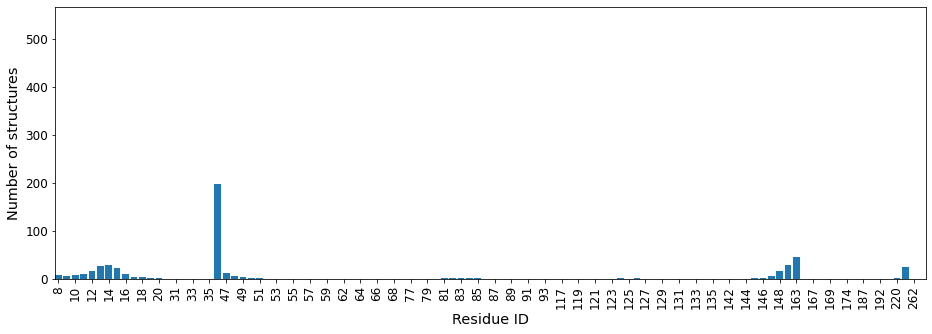

In [5]:
missing_pdb, missing_res = dist_analy.pca.hist_missing_residue(dist_mat_list_0, cdk2_klifs_ident)

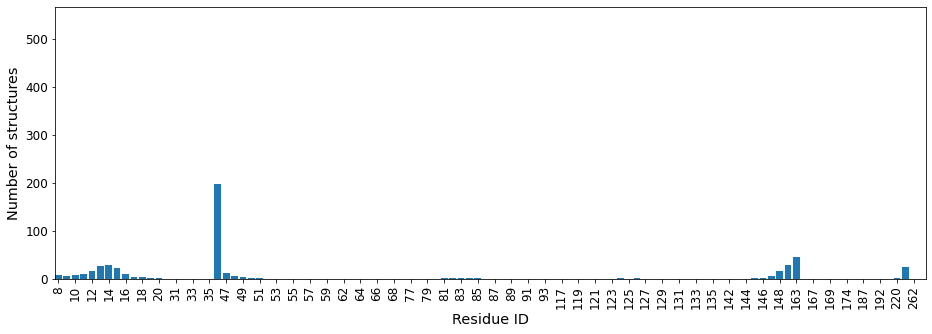

In [6]:
res_get = [145,146,147]
missing_dfg = dist_analy.pca.hist_missing_residue(dist_mat_list_0, cdk2_klifs_ident, res_get)

### perform PCA on the distance matrices

In [48]:
save_dir = "./datafiles/npy/CDK2/"
dist_mat_list_tut = []
dist_mat_pdb_tut = []
for proc_npy in glob(save_dir+'*.npy'):
    pdb = proc_npy.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    dist_mat = np.load(proc_npy)
    dist_mat_list_tut.append(dist_mat)
    dist_mat_pdb_tut.append(pdb) 

In [24]:
dist_mat_list_tut

[array([[ 0.        ,  5.52469013,  3.5729895 , ...,  0.        ,
         32.69291992, 35.13659974],
        [ 5.52469013,  0.        ,  5.76808408, ...,  0.        ,
         33.36113688, 32.63268754],
        [ 3.5729895 ,  5.76808408,  0.        , ...,  0.        ,
         28.89612074, 29.15493171],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [32.69291992, 33.36113688, 28.89612074, ...,  0.        ,
          0.        ,  7.66521265],
        [35.13659974, 32.63268754, 29.15493171, ...,  0.        ,
          7.66521265,  0.        ]]),
 array([[ 0.        ,  5.44425027,  3.74465446, ..., 39.46633895,
         35.73106627, 34.8331618 ],
        [ 5.44425027,  0.        ,  6.01624958, ..., 36.32027077,
         34.22206028, 32.87160096],
        [ 3.74465446,  6.01624958,  0.        , ..., 33.83858941,
         29.2536517 , 29.0101686 ],
        ...,
        [39.46633895, 36.32027077, 33.83858941, ...,  

removing residues not available in every structure
original length of residue list 104; remove 34 residues
PCA


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot PCA
cluster size: 137 g
cluster size: 6 r
cluster size: 113 c
cluster size: 217 m
cluster size: 93 y
[0.66987533 0.13291109]


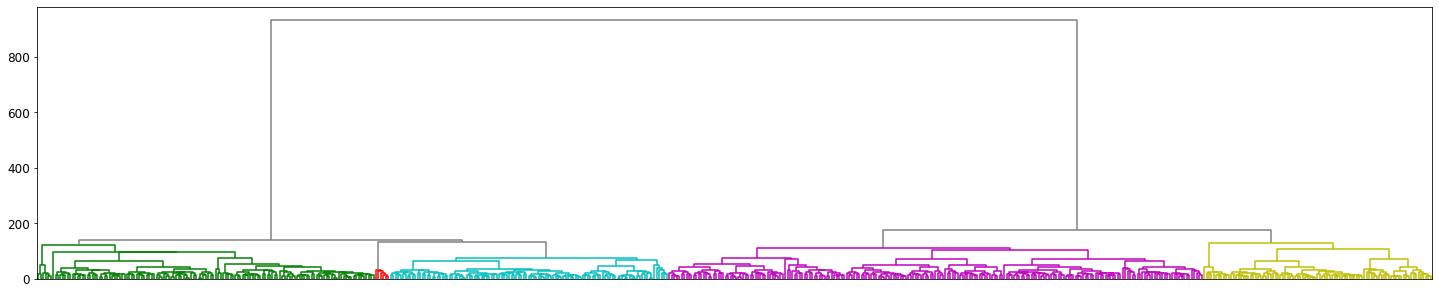

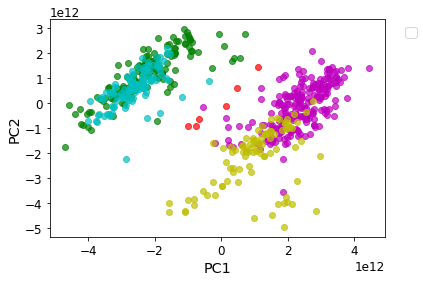

In [47]:
dist_mat_list_tut = np.array(dist_mat_list_tut)
dist_mats_tut, res_list_tut, ind_list_tut, inds_fc_tut, medoid_ind_list_tut, pca_tut = dist_analy.pca.run(dist_mat_list_tut, cdk2_klifs_ident, 5)


In [55]:
compare = dist_mat_list_0[0][0]

In [54]:
orig = [ 0.0,4.421590098595753,3.839714051853342,6.564501504303278,9.812206683514164,12.218417246108434,14.819903812103503,14.730390965619344,11.162265585444562,7.275343978122272,4.5528786498214515,3.571710094618544,2.6366687315626107,7.04780348761229,7.577214461792669,7.346765478766828,9.528140532129026,9.342604347825073,13.678685353497974,23.600957904288546,20.23345489529655,19.279163778545996,22.05056935772861,22.894237047781257,16.153460588988352,19.190352393846236,23.001241292591146,23.82130202151007,18.13495219183111,22.538710011888433,24.911971640157265,23.081124431015052,22.758930137420784,20.957251394207212,22.0310543097692,19.75269576538858,14.860448243575963,15.703372695061397,16.129103198876248,14.916131971794831,15.873309484792385,17.620338787889406,11.417185686499103,11.543645091564448,12.583016569964451,11.1646385521431,11.822257440945869,5.92147101656337,8.973927233937216,7.749065040377455,9.9960553719955,11.956354837491235,15.545507389596525,16.061594597050444,9.363041439617792,14.884844473490478,17.713614509749274,17.13485611261443,15.278680244052495,25.94135318367182,27.591616589101843,25.559792898222,30.213459566888396,32.443157260044835,30.559469334397807,30.891220079498318,26.314089799953177,26.38363780830839,20.82296218120755,25.04478756148672,20.392684889440137,22.799651949097814,19.186123787779543,16.992415425712732,14.87780229066108,16.364146021103572,15.816272158761057,12.84559477019262,12.495614190587032,18.634126247291555,17.837183998602473,18.771233230664414,15.826355644936072,14.972979997315164,18.308763939709312,19.15759400342329,21.368514361087435,23.336390830631885,27.491833496513106,22.47257550882853,24.6932905057224,23.46559969402018,28.14682223626674,35.39238829183473,33.23425463283327,27.329161823956472,30.61856513620454,29.620915397738813,23.687760172713674,23.03196693728089,44.36906969951027,0.0,33.55324248116715,35.57050265318161]

In [56]:
print(np.allclose(orig, compare))

True


In [62]:
dist_mat_list_0.shape

(534, 104, 104)

In [49]:
save_dir = "/Users/echen10/Google Drive/test_dist_analy/datafiles/npy/shortest/CDK2/"
dist_mat_list_0 = []
dist_mat_pdb_0 = []
for proc_npy in glob(save_dir+'*.npy'):
    pdb = proc_npy.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    dist_mat = np.load(proc_npy)
    dist_mat_list_0.append(dist_mat)
    dist_mat_pdb_0.append(pdb) 

In [14]:
feats_list = dist_analy.pca.triu_flatten(np.array(dist_mat_list_0), len(cdk2_klifs_ident))

In [16]:
feats_list.shape

(534, 5356)

In [ ]:
print()

In [81]:
with open('./tut_feat.npy', 'wb') as f:
    np.save(f, feats_list, allow_pickle=True)

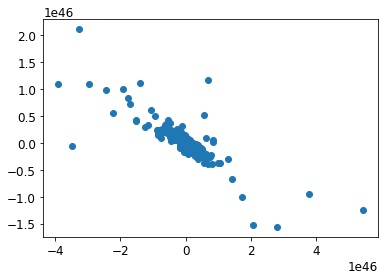

In [32]:
from sklearn import decomposition
npy_pca = decomposition.PCA()
a = npy_pca.fit_transform(feats_list)

plt.scatter(a[:,0], a[:,1])

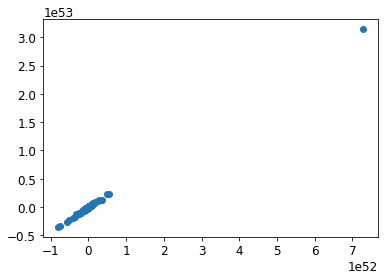

In [39]:
npy_pca = decomposition.PCA(svd_solver='full', random_state=42)
a = npy_pca.fit_transform(feats_list)

plt.scatter(a[:,0], a[:,1])

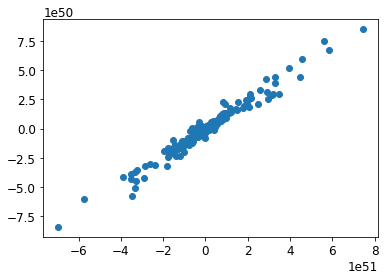

In [36]:
npy_pca = decomposition.PCA(random_state=42)
a = npy_pca.fit_transform(feats_list)

plt.scatter(a[:,0], a[:,1])

removing residues not available in every structure
original length of residue list 104; remove 32 residues
PCA, svd


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot PCA
cluster size: 239 g
cluster size: 87 r
cluster size: 5 c
cluster size: 203 m
[0.74200049 0.06076474]


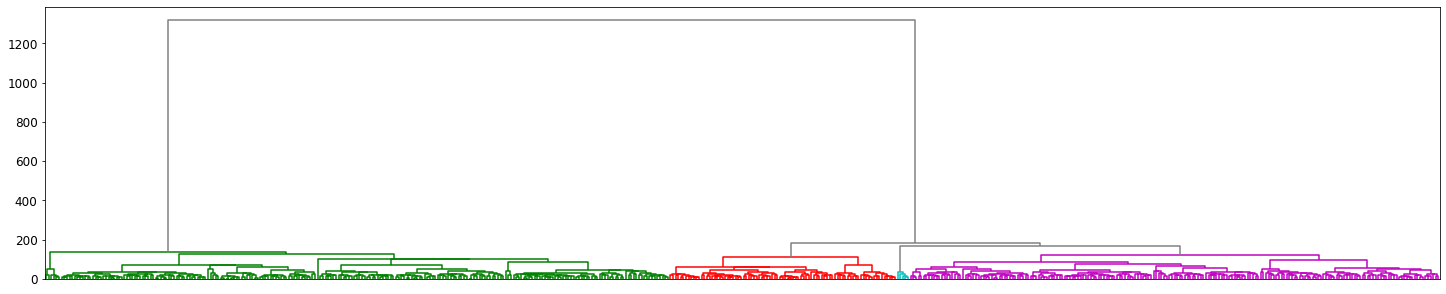

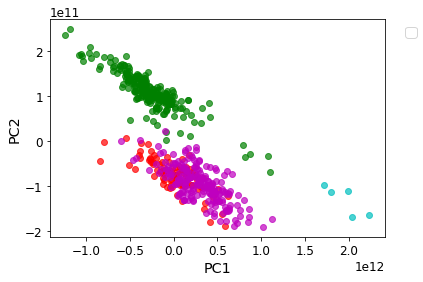

In [55]:
dist_mat_list_0 = np.array(dist_mat_list_0)
dist_mats_0, res_list_0, ind_list_0, inds_fc_0, medoid_ind_list_0, pca_0 = dist_analy.pca.run(dist_mat_list_0, cdk2_klifs_ident, 4)


In [45]:
dist_mat_list_0 = np.array(dist_mat_list_0)[:200]
dist_mats_0, res_list_0, ind_list_0, inds_fc_0, medoid_ind_list_0, pca_0 = dist_analy.pca.run(dist_mat_list_0, cdk2_klifs_ident, 4)


removing residues not available in every structure
original length of residue list 104; remove 13 residues
PCA


LinAlgError: SVD did not converge

In [ ]:
{'n_components': None,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 2556,
 '_fit_svd_solver': 'full',
 'mean_': array([ 5.36016226,  3.97057007,  7.2764091 , ..., 11.85215325,
        14.95555667,  7.80316375]),
 'noise_variance_': 0.0,
 'n_samples_': 534,
 'n_features_': 2556,
 'components_': array([[ 1.13412759e-03,  1.11188625e-04,  9.11940042e-04, ...,
         -1.21719977e-03, -1.15980216e-03,  6.07908562e-05],
        [-3.86995453e-03,  4.10923834e-03,  2.18979881e-03, ...,
          1.95108118e-03,  6.75970866e-03,  3.93304893e-03],

In [42]:
vars(pca_0)

{'n_components': None,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 2556,
 '_fit_svd_solver': 'full',
 'mean_': array([ 5.36016226,  3.97057007,  7.2764091 , ..., 11.85215325,
        14.95555667,  7.80316375]),
 'noise_variance_': 0.0,
 'n_samples_': 534,
 'n_features_': 2556,
 'components_': array([[ 1.19515550e+07, -4.56494265e+07, -2.06107214e+06, ...,
          3.89574665e+05,  1.74274592e+06,  7.76314086e+05],
        [-7.38408198e+07,  5.77296461e+06, -1.74621664e+07, ...,
          1.62227438e+05,  4.80679160e+05, -2.55695957e+05],
        [-2.01219117e+07,  1.24345013e+07, -3.49855835e+06, ...,
         -2.69525978e+04, -2.73173321e+05, -2.32662378e+05],
        ...,
        [ 4.86256960e+14, -2.76111643e+14, -4.41928451e+14, ...,
         -1.56716286e+13, -8.79442213e+12,  6.13529361e+12],
        [-2.58965994e+15,  7.12117453e+14,  5.47954154e+14, ...,
          1.29716127e+14,  1.31